# AIML Computer Vision : Capstone Project - Food 101 Detection

---

## PROBLEM STATEMENT

### DOMAIN: Food Industry

Can you generate proper business level details on Context, Data Description and Project Objective based on below details.

### CONTEXT: 
In the era of digital transformation, automated food detection using computer vision has become increasingly important in various sectors such as hospitality, healthcare, fitness, retail, and food delivery. Accurate identification of food items from images enables intelligent systems to recognize what a person is eating, streamline restaurant operations, or even automate checkout processes in cafeterias.

For example, in a smart cafeteria, cameras can detect and identify food items on a tray without manual input, enabling a frictionless billing experience. In diet and nutrition apps, users can take a picture of their meal, and the app can instantly classify the food and estimate nutritional content. In quality assurance for food production, automated systems can detect if the right type of food is being processed or if items are visually defective.

Such applications demand a robust food classification model capable of identifying food items from images with high accuracy, regardless of variations in presentation, lighting, or camera angles. This project aims to tackle this challenge by leveraging deep learning techniques to train a model that can automatically detect and classify different types of food from a diverse dataset of labeled food images.

### DATA DESCRIPTION:

The project uses a curated subset of the Food-101 dataset, a widely used benchmark for food classification tasks. This dataset includes:

500 images categorized into

10 distinct food classes (e.g., apple_pie, fried_rice, sushi)

Each class contains a balanced distribution of training and test images, generally split in a 70-30 ratio

Images vary in lighting, background, and angle to mimic real-world food photography conditions

Each image is labeled with the corresponding food class, enabling supervised learning approaches to be applied effectively.


### PROJECT OBJECTIVE: 
**The primary goal of this project is to:**

Develop a deep learning-based food identification model that can accurately classify food items from images.

**Key objectives include:**

Building a convolutional neural network (CNN) model to classify food images into one of the 10 defined categories

Evaluating model performance using standard metrics such as accuracy, precision, recall and confusion matrix.

Enabling a potential real-time application where the trained model can be integrated into camera-based systems for smart kitchens, restaurant automation, or diet-tracking apps

Ultimately, this solution aims to demonstrate the feasibility of intelligent, camera-driven food recognition systems, contributing toward innovations in food technology and AI-driven lifestyle tools.

### Import the Data

#### Load all necessary libararies 

In [107]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, ZeroPadding2D,Flatten, Activation
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from PIL import Image
from sklearn.decomposition import PCA
import joblib
from sklearn.preprocessing import LabelEncoder
import os
import glob
from tensorflow.keras.callbacks import EarlyStopping
import random
from tqdm import tqdm

# Import Input for defining input shape
from tensorflow.keras import Input

#### Utility Functions

In [91]:
# Define common image extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp', '*.tiff', '*.webp']

# Function to disply images from training_images
def load_and_display_images(folder_path, num_images=5):
    """
    Randomly selects and displays a given number of images from the specified folder.

    Args:
        folder_path (str): Path to the folder containing images.
        num_images (int): Number of images to display.
    """
    image_files = []

    # Collect all image paths in one list
    all_images = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, '**', ext), recursive=True))

    if len(image_files) < num_images:
        print(f"Not enough images in the folder. Found only {len(image_files)}.")
        return

    # Randomly select images
    selected_files = random.sample(image_files, num_images)

    # Plot images
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    for ax, file_name in zip(axes, selected_files):
        #image_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_name)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image_rgb)
        ax.set_title(file_name, fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    

# ✅ Function to Visualize the Images and Masks
def show_images_and_masks(images, masks):
    num = min(5, len(images))  # Show up to 5
    plt.figure(figsize=(12, 2 * num))

    for i in range(num):
        img = images[i]
        mask = masks[i]

        # Convert BGR to RGB if needed
        if img.shape[2] == 3 and np.max(img) > 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(num, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis("off")

        plt.subplot(num, 2, 2*i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

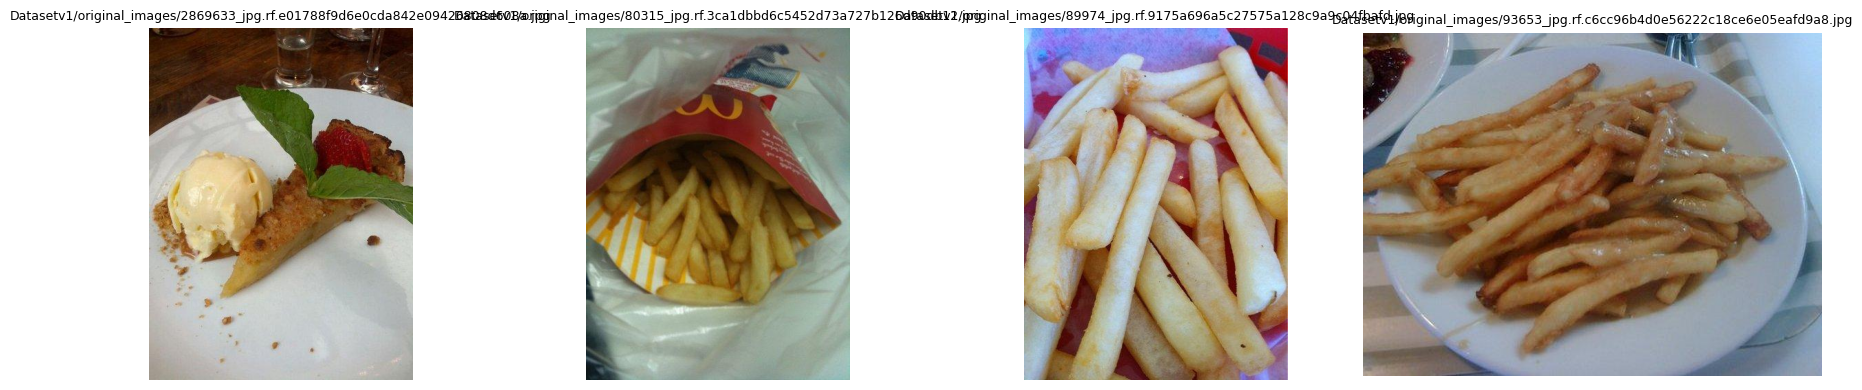

In [92]:
folder_path = 'Datasetv1/original_images'  # Replace with your folder path
# Example usage
load_and_display_images(folder_path, num_images=4)

### Exploratory Data Analysis

#### Load the Dataset

In [102]:
data = pd.read_csv('Datasetv1/original_images/_annotations.csv')

# Write your code here
# Find number of rows and columns in data set
num_rows, num_columns = data.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 108
Number of columns: 8


#### Print initial 5 rows from the dataset

In [103]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,2909830_jpg.rf.bb9125215f38f22139f72d04f19e693...,512,512,Apple Pie,210,43,397,259
1,108743_jpg.rf.260978b4f8ae78f4ebb41f48ef501679...,512,384,French Fries,50,3,442,383
2,149278_jpg.rf.86187fd5bd1698133cb7a973c6060449...,512,384,French Fries,33,0,260,167
3,2986199_jpg.rf.ac0b99e71100520e6608ef72b12ee27...,512,512,Apple Pie,28,37,291,233
4,2934928_jpg.rf.c8f427a0d3e7ba9342fe37276fb15ab...,512,512,Apple Pie,9,54,463,465


**Observations**

The dataset contains below list of columns.

| Column     | Description                                                       |
| ---------- | ----------------------------------------------------------------- |
| `filename` | Image file name where the object is located                       |
| `width`    | Width of the image in pixels                                      |
| `height`   | Height of the image in pixels                                     |
| `class`    | The label/class of the object (e.g., "Apple Pie", "French Fries") |
| `xmin`     | Top-left x-coordinate of the bounding box                         |
| `ymin`     | Top-left y-coordinate of the bounding box                         |
| `xmax`     | Bottom-right x-coordinate of the bounding box                     |
| `ymax`     | Bottom-right y-coordinate of the bounding box                     |


#### Check the dataset data structure

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  108 non-null    object
 1   width     108 non-null    int64 
 2   height    108 non-null    int64 
 3   class     108 non-null    object
 4   xmin      108 non-null    int64 
 5   ymin      108 non-null    int64 
 6   xmax      108 non-null    int64 
 7   ymax      108 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 6.9+ KB


**Observations from DataFrame Info**

1. Dataset Size

   - The dataset contains 108 entries (rows).

   - Each entry likely corresponds to an annotated object (bounding box) within an image.

2. Column Summary

   - There are a total of 8 columns in the dataset.

3. Column types:

   - 6 numerical columns (int64): width, height, xmin, ymin, xmax, ymax

   - 2 object columns: filename and class

4. Data Completeness

   - No missing values across all columns — each column has exactly 108 non-null values.

   - This indicates the dataset is clean and ready for analysis or model training.

5. Column Meanings (based on naming convention)

   - filename: Name of the image file containing the annotated object.

   - width / height: Dimensions of the image in pixels.

   - class: Category or label of the object detected in the image.

   - xmin, ymin, xmax, ymax: Coordinates of the bounding box around the object.

6. Memory Usage

   - The memory usage of the DataFrame is relatively small at 6.9 KB, indicating lightweight and manageable data — ideal for quick prototyping.

7. Ideal Use Case

   - The structure and completeness of this dataset make it well-suited for object detection tasks, such as training a YOLO, SSD, or Faster R-CNN model.

#### Check the Statistical Summary of Numerical Columns 

In [104]:
data.describe()

,width,height,xmin,ymin,xmax,ymax
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,472.324074,482.287037,49.620370,75.750000,426.574074,409.592593
std,60.224165,56.224193,78.476226,78.860237,76.252924,90.774553
min,342.000000,341.000000,0.000000,0.000000,206.000000,167.000000
25%,384.000000,512.000000,0.000000,17.000000,381.750000,354.750000
50%,512.000000,512.000000,11.500000,59.000000,425.500000,400.500000
75%,512.000000,512.000000,74.250000,109.250000,504.500000,508.250000
max,512.000000,512.000000,399.000000,394.000000,512.000000,512.000000


**Descriptive Analysis: Image and Bounding Box Dimensions**
1. Image Dimensions (width and height)
   - **Max Width & Height** = 512 pixels → Confirms that images are capped at 512×512 size.
   - **Min Width & Height** = 342 (width), 341 (height) → Some images are smaller, possibly unstandardized.
   - **Mean Width & Height** ≈ 472 × 482 → Most images are close to full resolution.
   - **Std. Deviation** is moderate → Shows some variability in image sizes.

**Observation**: While 75% of images are already at 512×512, resizing all images to this size is a good idea for model uniformity.

2. Potential Outliers
   - Some bounding boxes start at 0 and go up to 512, which might indicate:
     - Full-image annotations or
     - Incorrect/loosely defined boxes.

✅ Conclusion
 - The dataset has:
   - Clean, non-null, and non-duplicate entries.
   - Mostly standardized image sizes.
   - Diverse and well-spread bounding boxes.

- This suggests the dataset is in **good shape** for object detection training, possibly using YOLO or SSD.

#### Show number of unique classes

In [97]:
data['class'].unique()

array(['Apple Pie', 'French Fries'], dtype=object)

#### Show number of items in each classes

In [100]:
data['class'].groupby(data['class']).count()

class
Apple Pie       55
French Fries    53
Name: class, dtype: int64

**Observations on Class Distribution**
1. Total Classes
   - The dataset contains 2 food categories:
     - `Apple Pie`
     - `French Fries`

2. Instance Counts
   - `Apple Pie` has **55 annotated instances**.
   - `French Fries` has **53 annotated instances**.

3. Balanced Dataset
   - The class distribution is **nearly balanced**, with a difference of only 2 instances between the two classes.
   - This is ideal for training classification or object detection models, as it reduces the risk of model bias toward a dominant class.

4. Label Format
   - Class names are in **title case with spaces**, e.g., "Apple Pie", which is clean and human-readable.
   - If required by the model, class names may need to be transformed (e.g., lowercase, snake_case) for consistency.

5. Implications for Modeling
   - With balanced labels and sufficient samples per class, the dataset is **well-suited for binary classification or object detection tasks**.
   - Each class having over 50 samples is adequate for initial training and prototyping in deep learning tasks (especially transfer learning).

#### Check for Duplicate Records

In [101]:
# Check for complete duplicate rows
duplicate_rows = data[data.duplicated()]

# Display the duplicate rows
print("Number of duplicate rows:", duplicate_rows.shape[0])
print(duplicate_rows)

Number of duplicate rows: 0
Empty DataFrame
Columns: [filename, width, height, class, xmin, ymin, xmax, ymax]
Index: []


**Observations: Duplicate Check**

1. No Duplicate Records Found
   - The dataset has **zero** completely identical records (rows) across all columns.

2. Columns Checked
   - The duplicate check was performed on the following columns:
     - filename
     - width
     - height
     - class
     - xmin
     - ymin
     - xmax
     - ymax

3. Data Integrity Looks Good
   - Since no duplicate rows exist, it indicates good practices in data annotation and exporting.

#### Univariant Analysis

/var/folders/j_/t_ptgzfd4knc6x338gjxpgpc0000gp/T/ipykernel_87197/1229719718.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="class", palette="Set2")


[<Figure size 1400x500 with 2 Axes>,
 <Figure size 700x500 with 1 Axes>,
 <Figure size 1000x600 with 1 Axes>,
 <Figure size 1000x600 with 2 Axes>,
 <Figure size 1400x500 with 2 Axes>]

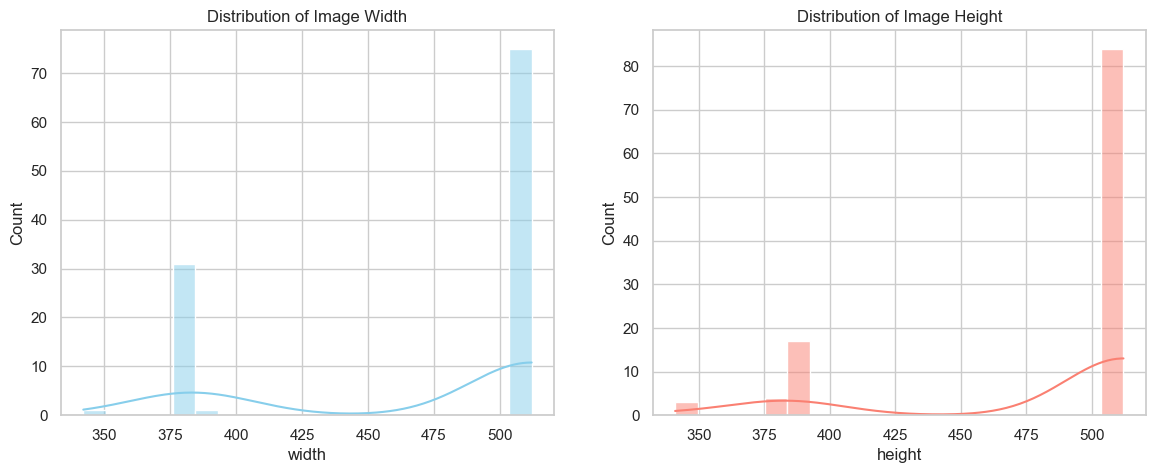

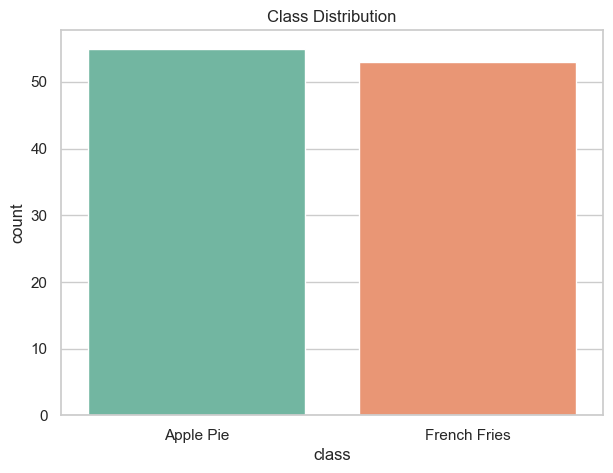

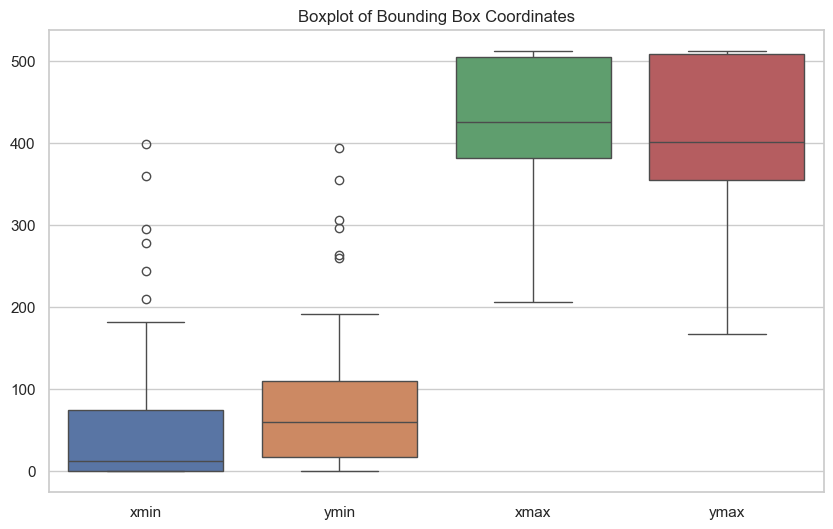

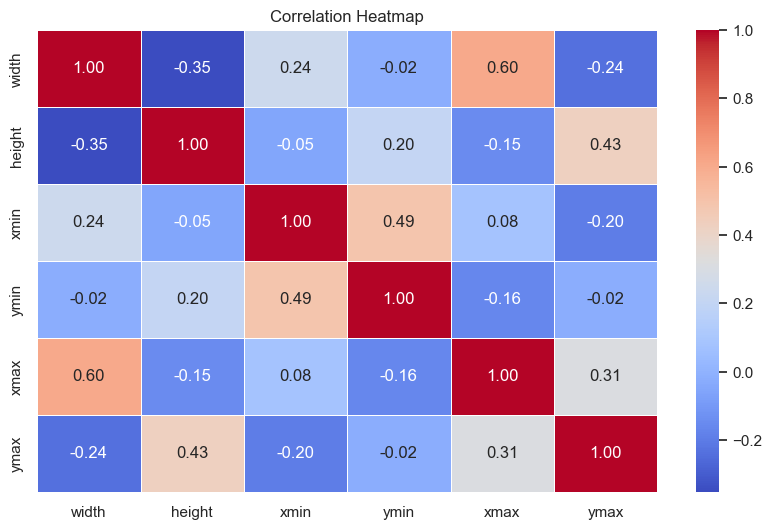

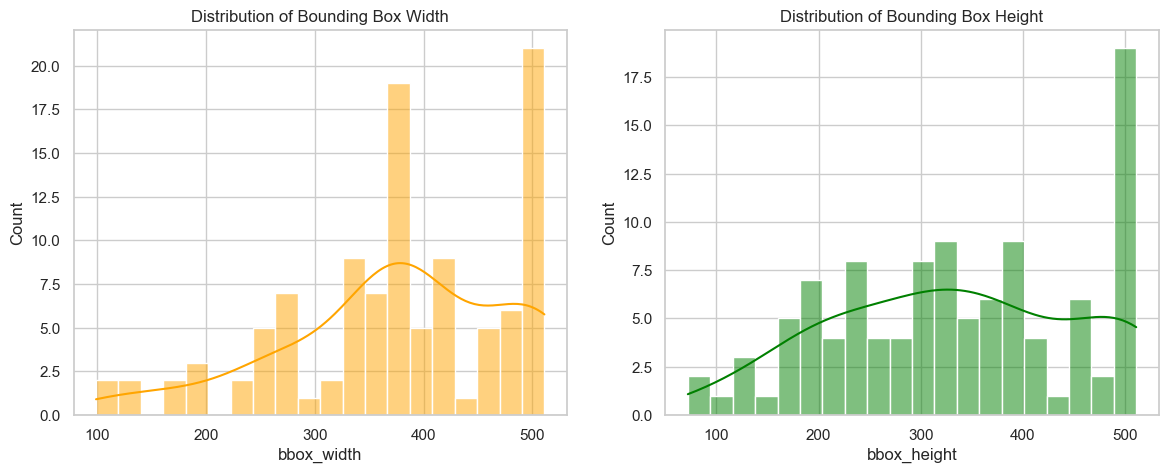

In [108]:

# Set style
sns.set(style="whitegrid")

# Initialize a list to store plots
figures = []

# Plot 1: Distribution of image width and height
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data["width"], bins=20, kde=True, ax=ax1[0], color="skyblue").set_title("Distribution of Image Width")
sns.histplot(data["height"], bins=20, kde=True, ax=ax1[1], color="salmon").set_title("Distribution of Image Height")
figures.append(fig1)

# Plot 2: Class distribution
fig2, ax2 = plt.subplots(figsize=(7, 5))
sns.countplot(data=data, x="class", palette="Set2")
plt.title("Class Distribution")
figures.append(fig2)

# Plot 3: Boxplot for bounding box coordinates
fig3, ax3 = plt.subplots(figsize=(10, 6))
sns.boxplot(data=data[["xmin", "ymin", "xmax", "ymax"]])
plt.title("Boxplot of Bounding Box Coordinates")
figures.append(fig3)

# Plot 4: Heatmap for correlation
fig4, ax4 = plt.subplots(figsize=(10, 6))
corr = data[["width", "height", "xmin", "ymin", "xmax", "ymax"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
figures.append(fig4)

# Plot 5: Bounding box width and height distribution
data['bbox_width'] = data['xmax'] - data['xmin']
data['bbox_height'] = data['ymax'] - data['ymin']

fig5, ax5 = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data["bbox_width"], bins=20, kde=True, ax=ax5[0], color="orange").set_title("Distribution of Bounding Box Width")
sns.histplot(data["bbox_height"], bins=20, kde=True, ax=ax5[1], color="green").set_title("Distribution of Bounding Box Height")
figures.append(fig5)

figures


**Observations**


#### Display images with bounding box

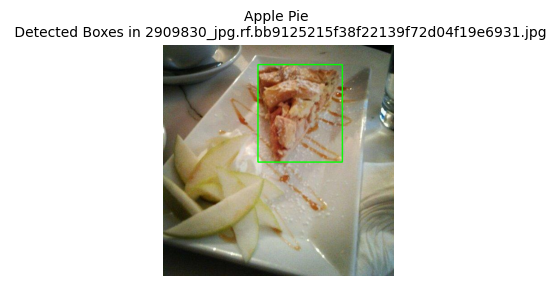

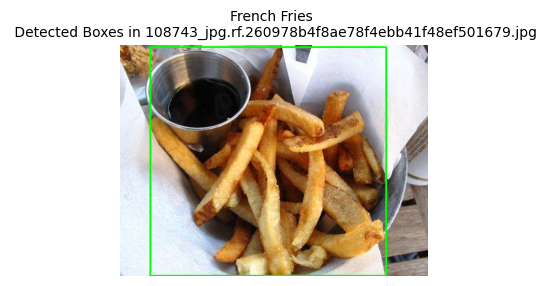

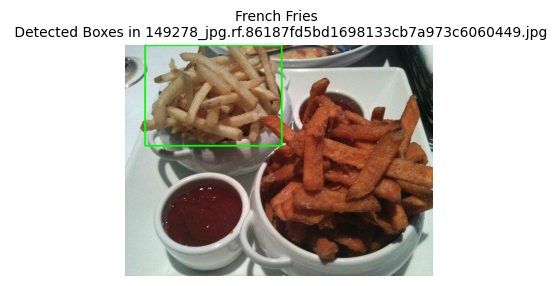

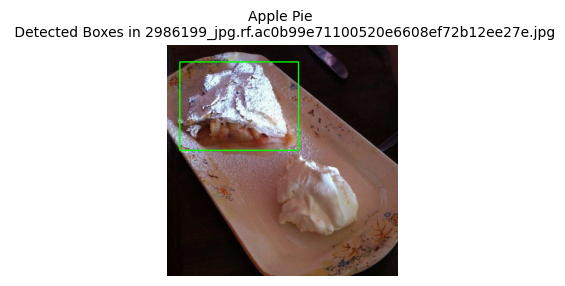

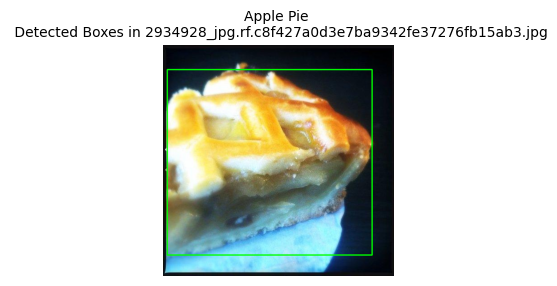

In [94]:
import pandas as pd
import os
import glob
import cv2
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Datasetv1/original_images/_annotations.csv')

# Get first 5 unique image names
sample_images = df[:5]

# Define folder and image extensions
folder_path = 'Datasetv1/original_images'
image_extensions = ['*.jpg', '*.jpeg', '*.png']

# Collect all image paths
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(folder_path, '**', ext), recursive=True))

# Create a dict for quick lookup: {filename: full_path}
image_dict = {os.path.basename(path): path for path in image_files}


# Process and display each image
for index, imgdata in sample_images.iterrows():
    image_path = image_dict.get(imgdata['filename'])
    if not image_path:
        print(f"Image file not found for: {imgdata['filename']}")
        continue

    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Could not read image: {image_path}")
        continue

    # Draw rectangles for annotations from the DataFrame
    for _, row in df[df['filename'] == imgdata['filename']].iterrows():
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])
        label = row['class'] if 'class' in row else ''

        # Draw rectangle
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # Convert to RGB for display in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.figure(figsize=(5, 3))
    plt.imshow(image_rgb)
    plt.title(f"Class: ")
    plt.title(f"{imgdata['class']} \n Detected Boxes in {imgdata['filename']}", fontsize=10 )
    plt.axis('off')
    plt.show()
